## Alex net 

In [51]:
import torch
from torch import nn
import torchvision
net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10)).to('cuda')


In [5]:
#import fashion dataset
fashionDataset = torchvision.datasets.FashionMNIST(root='./fashion', train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:02<00:00, 10188409.37it/s]


Extracting ./fashion\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./fashion\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 1372327.09it/s]


Extracting ./fashion\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./fashion\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 9105379.64it/s]


Extracting ./fashion\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./fashion\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 1101590.58it/s]

Extracting ./fashion\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./fashion\FashionMNIST\raw



In [6]:
## Optimizer
import torch.optim as optim
## using adam
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [10]:
!wandb login

wandb: Currently logged in as: chstrokin. Use `wandb login --relogin` to force relogin


In [11]:
import wandb 
wandb.init(project="fashion-mnist")
wandb.watch(net)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chstrokin. Use `wandb login --relogin` to force relogin


[]

In [12]:
## Loss function crossentropy and dice
loss = nn.CrossEntropyLoss()
## Load data
trainDataLoader = torch.utils.data.DataLoader(fashionDataset, batch_size=256, shuffle=True)


input shape is torch.Size([256, 1, 28, 28])


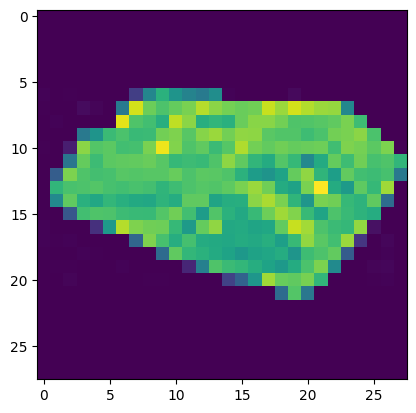

input shape is torch.Size([256, 1, 28, 28])


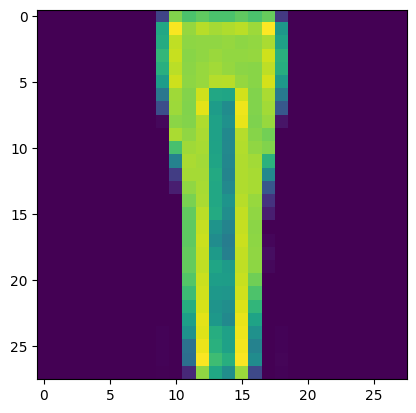

input shape is torch.Size([256, 1, 28, 28])


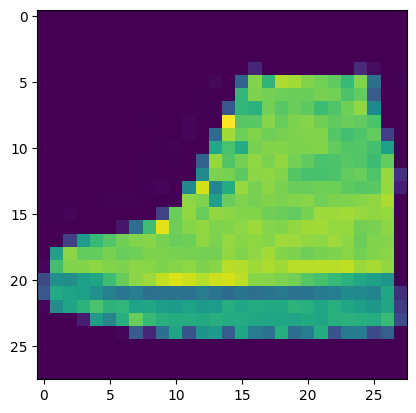

input shape is torch.Size([256, 1, 28, 28])


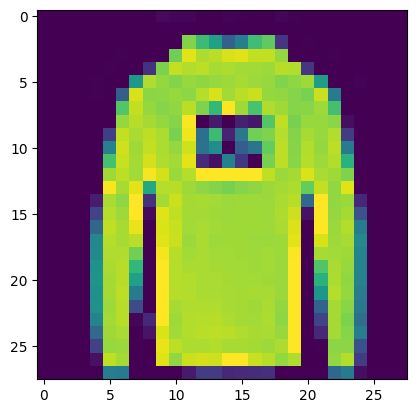

In [18]:
import matplotlib.pyplot as plt
for i, data in enumerate(trainDataLoader, 0):
    inputs, labels = data
    print(f"input shape is {inputs.shape}")
    plt.imshow(inputs[0][0].detach().numpy())
    plt.show()
    if i >= 3:
        break

In [61]:
from tqdm import tqdm
import torch.nn.functional as F
epoch = 500 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#label 
label = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
for e in tqdm(range(epoch)):
    dat = None
    output = None
    for i, data in enumerate(trainDataLoader, 0):
        inputs, labels = data
        labels = labels.to(device)
        optimizer.zero_grad()
        inputs = F.interpolate(inputs, size=(224, 224)).to(device)
        outputs = net(inputs).to(device)
        l = loss(outputs, labels).to(device)
        l.backward()
        optimizer.step()
        if(i == 0):
            dat = inputs[0][0].detach().cpu().numpy()
            output = label[torch.argmax(outputs[0]).item()]
    wandb.log({"loss": l.item()})
    wandb.log({"epoch": e})
    ## loging the input img and output label 
    wandb.log({"input": [wandb.Image(dat)]})
    print(f"epoch {e} batch {i} loss {l.item()}")

  0%|          | 0/500 [00:00<?, ?it/s]